# Sentence emojification
In this notebook, we build and train NLP models to emojify sentences. We consider two differen models:
- **Emojifier-v1:** a base-line model that uses an average of the word vectors to predict an emojy by a softmax activation.
- **Emojifier-v2:** a more sophisticated model with LSTM which we will develop using Keras layers.

# <span style="color:blue"> DATA </span>

In [117]:
import numpy as np
import emoji
import pandas as pd

In [118]:
train_data = pd.read_csv('train_emoji.csv', header=None)
valid_data = pd.read_csv('valid_emoji.csv', header=None)

In [119]:
X_train, Y_train = train_data[0].values, train_data[1].values
X_valid, Y_valid = valid_data[0].values, valid_data[1].values

In [120]:
print(f"Shape of data:")
print(f"Train:")
print(f"X_train.shape = {X_train.shape}, Y_train.shape = {Y_train.shape}")
print(f"Valid:")
print(f"X_valid.shape = {X_valid.shape}, Y_valid.shape = {Y_valid.shape}")

Shape of data:
Train:
X_train.shape = (132,), Y_train.shape = (132,)
Valid:
X_valid.shape = (56,), Y_valid.shape = (56,)


## Sample data
The train and valid data include sentences (string) and labels (0, 1, 2, 3, 4) corresponding to 5 different emojis.

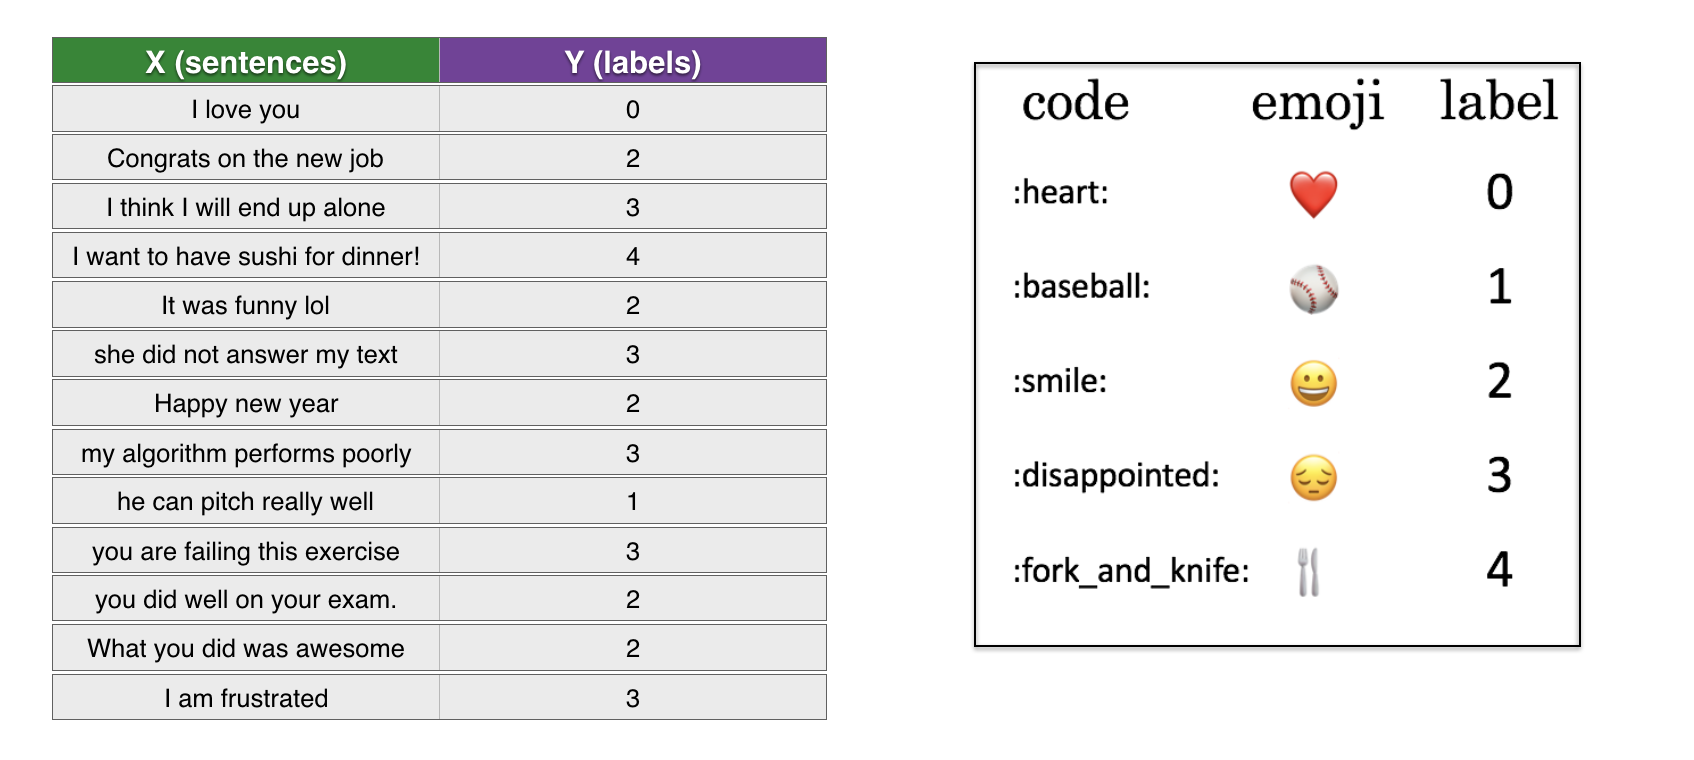

<center> image taken directly from the course site </center>

In [121]:
emoji_dictionary = {"0": "\u2764\uFE0F",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}
def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[str(label)], language='alias')

In [122]:
np.random.seed(seed=1)
index = np.random.randint(len(X_train),size=(10,))
for i in index:
    print(X_train[i], label_to_emoji(Y_train[i]))

he is laughing 😄
The baby is adorable ❤️
he likes baseball ⚾
What is wrong with you 😞
he did an amazing job 😄
The chicago cubs won again ⚾
So sad you are not coming 😞
this guy was such a joke 😄
I missed you ❤️
her smile is so charming 😄


# <span style="color:blue"> Emojifier-v1 </span>

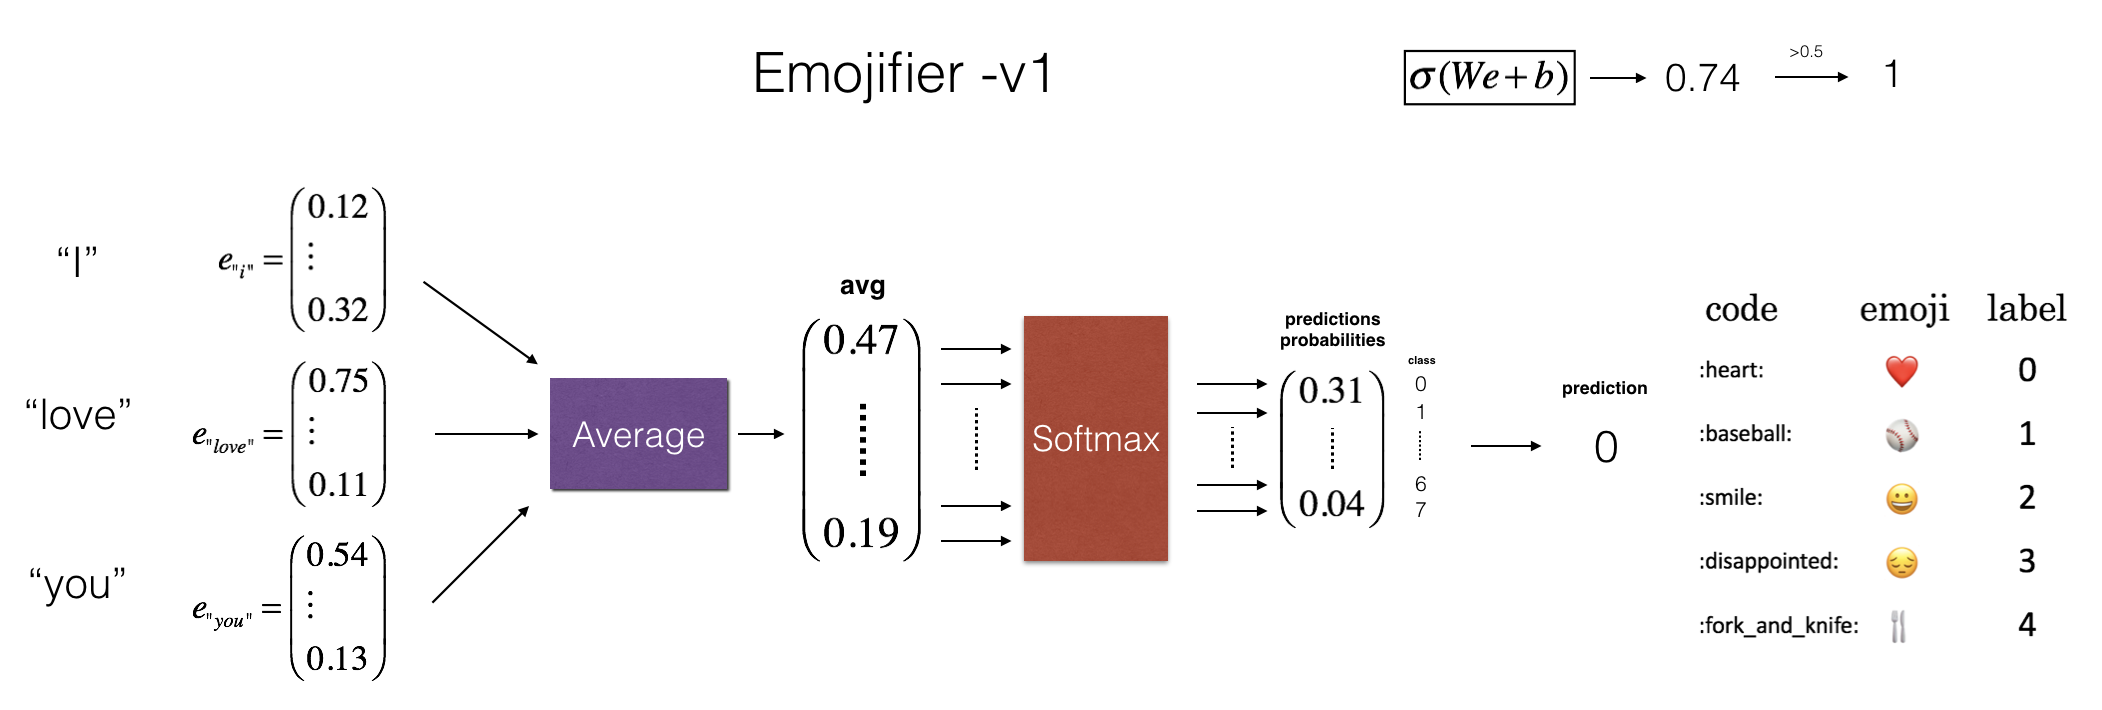

<center> image taken directly from the course site </center>

**Notes** To implement Emojifier-v1, we need a pretrained vector embedding (we use GloVe) and a method to split each sentence into its words. Below, we first read the pretrained GloVe embeddings, and then implement the model.

## Average embedding

In [123]:
def read_vecs(file):
    with open(file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [124]:
word_to_index, index_to_word, word_to_vec_map = read_vecs('glove.6B.50d.txt')

In [125]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    INPUT:
    sentence: a string including multiple words
    word_to_vec_map: dictionary mapping every word in a vocabulary into its 50-dimensional vector embedding
    
    OUTPUT:
    avg: average of the vector embeddings (see figure above)
    """
    
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split() # as is, this line of code interprets ",", ".", ";", "?", etc. as part of the word
    avg = np.zeros(word_to_vec_map[any_word].shape)
    
    count = 0
    for w in words:
        if w in word_to_vec_map.keys():
            avg += word_to_vec_map[w]
            count +=1
          
    if count > 0:
        avg /= count
    
    return avg

## Softmax layer + model
For each training example $(i)$, the `Softmax` layer does the following steps:
$$z^{(i)}=Wavg^{(i)}+b\Rightarrow a^{(i)}=\mathrm{softmax}\left(z^{(i)}\right)\Rightarrow \mathcal{L}^{(i)}=-\sum_{k=0}^{n_c-1}Y_{oh,k}^{(i)}\ln\left(a_k^{(i)}\right).$$
Here, $W$ (`W.shape = (n_c, emb_dim)`) and $b$ (`b.shape = (n_c)`) are the weight matrix and bias of the layer, where `n_c` and `emb_dim` denote the number of classes and size of the emebedding vectors, respectively. The last operation computes the loss using one-hot encoded labels $Y_{oh}$ (`Y_oh.shape = (m,n_c)`).

In [130]:
def convert_to_one_hot(Y, n_c):
    return np.eye(n_c)[Y]

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return e_x/e_x.sum()

In [131]:
def model(X, Y, word_to_vec_map, learning_rate, num_iterations):
    """
    INPUT:
    X: numpy array of sentences as strings; shape = (m,)
    Y: numpy array of integers 0, 1, 2, 3, 4; shape = (m,)
    
    OUTPUT:
    pred: vector of predictions; shape = (m,)
    W: weight matrix of the softmax layer; shape (n_c, emb_dim)
    b: bias of the softmax layer; shape = (n_c,)
    """
    
    any_word = list(word_to_vec_map.keys())[0]
        
    m = Y.shape[0]
    n_c = len(np.unique(Y))
    emb_dim = word_to_vec_map[any_word].shape[0]
    
    W = np.random.randn(n_c, emb_dim)/np.sqrt(emb_dim)
    b = np.zeros((n_c,))
    
    Y_oh = convert_to_one_hot(Y, n_c) 
    
    for t in range(num_iterations):
        cost = 0
        dW = 0
        db = 0
        for i in range(m):
            avg = sentence_to_avg(X[i], word_to_vec_map)
            z = np.dot(W,avg)+b
            a = softmax(z)
            cost += -np.dot(Y_oh[i,:],np.log(a))
            
            # Compute gradients
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_c,1), avg.reshape(1, emb_dim))
            db += dz

            W = W - learning_rate*dW
            b = b - learning_rate*db
        
        if t%100 == 0:
            print(f"Epoch: {t}\ncost = {cost}")
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [132]:
# code snippet taken from the course site with minor changes
def predict(X, Y, W, b, word_to_vec_map):
    m = X.shape[0]
    pred = np.zeros(m,dtype=int)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0] 
    
    for i in range(m):
        words = X[i].lower().split()
        avg = np.zeros((emb_dim,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1
         
        if count > 0:
            avg = avg/count

        z = np.dot(W, avg)+b
        a = softmax(z)
        pred[i] = np.argmax(a)
         
    print(f"accuracy = {np.mean(pred==Y):.2f}")
    
    return pred

In [133]:
pred, W, b = model(X_train, Y_train, word_to_vec_map, learning_rate=0.01, num_iterations=401)

Epoch: 0
cost = 385.08018649220503
accuracy = 0.63
Epoch: 100
cost = 48.60500338247008
accuracy = 0.93
Epoch: 200
cost = 1.6985231970741703
accuracy = 1.00
Epoch: 300
cost = 0.3204689509681649
accuracy = 1.00
Epoch: 400
cost = 0.22215707846352153
accuracy = 1.00


## Validation data

In [134]:
print("Train data:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Validation data:')
pred_valid = predict(X_valid, Y_valid, W, b, word_to_vec_map)

Train data:
accuracy = 1.00
Validation data:
accuracy = 0.91


**Notes:** it is a remarkable accuracy given how small our train data set is. Below we test our model with some specific sentences.

In [135]:
X_test = np.array(["I am not in a good mood",
                   "I love you",
                   "funny lol",
                   "Let us play with a ball",
                   "Food is ready",
                   "not feeling happy"])
Y_test = np.array([3, 0, 2, 1, 4, 3])

pred = predict(X_test, Y_test, W, b, word_to_vec_map)
for i in range(len(X_test)):
    print(X_test[i], label_to_emoji(int(pred[i])))

accuracy = 0.83
I am not in a good mood 😄
I love you ❤️
funny lol 😄
Let us play with a ball ⚾
Food is ready 🍴
not feeling happy 😞


**Notes:** This model does not consider the order of words. For example it might interpret "not in a good mood" as a positive sentence an emojify it with a smile (as you can see above). But, still it does a great job, even with such sentences.

# <span style="color:blue"> Emojifier-v2 </span>
Here we use LSTM and Keras layers to build a better model.

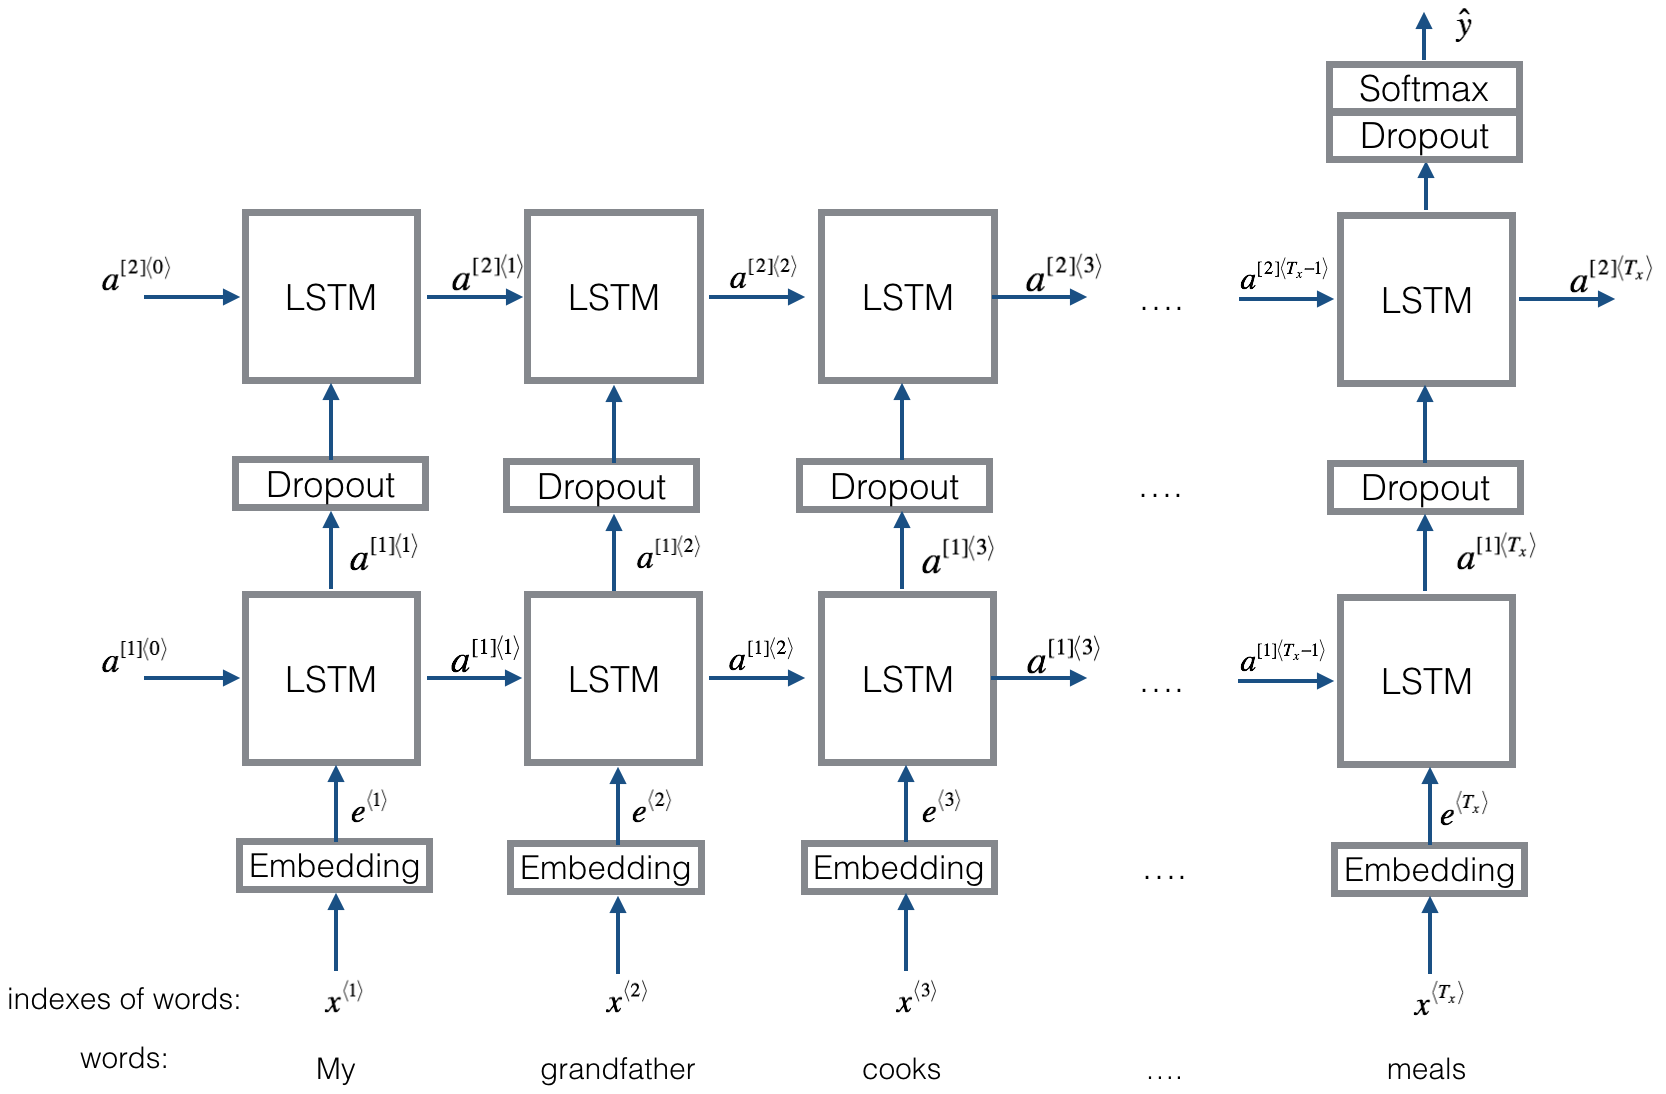

<center> image taken directly from the course site </center>

In [136]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Model
tfl = tf.keras.layers

## Step 1: break each sentence into a list of indices
We first break down each sentence into its seperate words and use `word_to_index(word)` to tranlate each word to its corresponding index. We consider a maximum length `max_len` (length of (number of words in) the longest sentence) for the list. If a sentence is shorter than the `max_len`, we pad the rest of the list with zeros.

In [137]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    INPUT:
    X: batch (size m) of sentences (strings); shape (m,)
    word_to_index: a dictionary that maps each word to its index
    max_len: maximum number of words in a sentence
    
    OUPUT:
    X_indices: batch (size m) of indices corresponding to words in the sentences from X; shape = (m, max_len)
    """
    
    m = X.shape[0]
    X_indices = np.zeros((m, max_len), dtype=int)
    
    for i in range(m):
        sentence_words = X[i].lower().split()
        
        j = 0
        for w in sentence_words:
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
                j += 1
                if j == max_len:
                    break
    
    return X_indices

**Notes:** the code above passes words that are not available in the dictionary. The following example makes it clear (the word "yoohoo" does not exist in the dictionary; see the cell block with function `checkKey(dic, key)` below). Please also note that the code interperets a sentence like "I am fine." as ["I", "am", "fine."] and does not find an index for the last word (although the dictionary includes "." as a separate key). Lastly, if a sentence is longer than `max_len`, it will be truncated.

In [138]:
sentences_to_indices(np.array(['I am fine',
                               'I am fine.',
                               'She said hi',
                               'I think she said yoohoo',
                               'I really wanted to at least try to underatand what it means to talk a lot']),
                     word_to_index, 5)

array([[185457,  52943, 148444,      0,      0],
       [185457,  52943,      0,      0,      0],
       [327864, 315709, 178126,      0,      0],
       [185457, 357970, 327864, 315709,      0],
       [185457, 302352, 383072, 360915,  62065]])

In [139]:
def checkKey(dic, key):
    if key in dic.keys():
        print("Present, ", end =" ")
        print("index =", dic[key])
    else:
        print("Not present")
        
checkKey(word_to_index,"yoohoo")

Not present


## Step 2: pretrained embedding layer
- **Embedding matrix:** `emb_matrix` a matrix of shape `(vocab_size,emb_dim)` that stores the embeddings of all individual words in the dictionary. Note that `vocab_size=len(word_to_vec_map)+1` (400001 here). The `+1` is added to account for unknowns.
- **tfl.Embedding():** Keras embedding layer; `input_dim = vocab_size`, `output_dim = emb_dim`; `set trainable = False` to freeze the weights. Finally use the method `.set_weights[emb_matrix]` to pass the embedding matrix to the layer.

In [140]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_size = len(word_to_vec_map)+1
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
    
    emb_matrix = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    
    emb_layer = tfl.Embedding(vocab_size, emb_dim, trainable=False, name="emb_layer")
    emb_layer.build((None,))
    emb_layer.set_weights([emb_matrix])
    
    return emb_layer

In [141]:
# Tests taken directly from the course site with minor changes
def pretrained_embedding_layer_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4], 
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0], 
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])
        
    # Create a word_to_index dictionary
    word_to_index = {}
    for idx, val in enumerate(list(word_to_vec_map.keys())):
        word_to_index[val] = idx;
        
    np.random.seed(1)
    embedding_layer = target(word_to_vec_map, word_to_index)
    
    assert type(embedding_layer) == tfl.Embedding, "Wrong type"
    assert embedding_layer.input_dim == len(list(word_to_vec_map.keys())) + 1, "Wrong input shape"
    assert embedding_layer.output_dim == len(word_to_vec_map['a']), "Wrong output shape"
    assert np.allclose(embedding_layer.get_weights(), 
                       [[[ 3, 3], [ 3, 3], [ 2, 4], [ 3, 2], [ 3, 4],
                       [-2, 1], [-2, 2], [-1, 2], [-1, 1], [-1, 0],
                       [-2, 0], [-3, 0], [-3, 1], [-3, 2], [ 0, 0]]]), "Wrong values"
    print("\033[92mAll tests passed!")
       
    
pretrained_embedding_layer_test(pretrained_embedding_layer)

All tests passed!


**Note:** the `emb_layer` gets list of indices as an input and returns the corresponding embeddings as the output. See example below.

In [142]:
emb_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
sentence = np.array(["I am fine"])
indices = sentences_to_indices(sentence, word_to_index, 3)
print(f"sentence: {sentence}")
print(f"indices: {indices}")
print(f"embeddings:\n{emb_layer(indices)}")

sentence: ['I am fine']
indices: [[185457  52943 148444]]
embeddings:
[[[ 1.1891e-01  1.5255e-01 -8.2073e-02 -7.4144e-01  7.5917e-01
   -4.8328e-01 -3.1009e-01  5.1476e-01 -9.8708e-01  6.1757e-04
   -1.5043e-01  8.3770e-01 -1.0797e+00 -5.1460e-01  1.3188e+00
    6.2007e-01  1.3779e-01  4.7108e-01 -7.2874e-02 -7.2675e-01
   -7.4116e-01  7.5263e-01  8.8180e-01  2.9561e-01  1.3548e+00
   -2.5701e+00 -1.3523e+00  4.5880e-01  1.0068e+00 -1.1856e+00
    3.4737e+00  7.7898e-01 -7.2929e-01  2.5102e-01 -2.6156e-01
   -3.4684e-01  5.5841e-01  7.5098e-01  4.9830e-01 -2.6823e-01
   -2.7443e-03 -1.8298e-02 -2.8096e-01  5.5318e-01  3.7706e-02
    1.8555e-01 -1.5025e-01 -5.7512e-01 -2.6671e-01  9.2121e-01]
  [ 3.4664e-01  3.9805e-01  4.8970e-01 -5.1421e-01  5.4574e-01
   -1.2005e+00  3.2107e-01  7.4004e-01 -1.4979e+00 -1.9651e-01
   -1.2631e-01 -3.7703e-01 -6.2569e-01  3.8792e-02  1.0579e+00
    7.7199e-01 -1.8589e-01  1.3032e+00 -7.2128e-01  4.0231e-01
    6.6442e-02  1.2315e+00  9.3956e-01  1.3903e

## Build the model
A short outline of the Emojifier-v2 is:
1. Pass the inputs (list of indices) to the `emb_layer`
2. `tfl.LSTM` with `return_sequences=True` as we need all of the output activations for the next layer
3. `tfl.Dropout`  layer
4. `tfl.LSTM` with `return_sequences=True` as we only need the last output
5. `tfl.Dropout`  layer
6. `tfl.Dense` layer with softmax activation

In [143]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = tfl.Input(shape=input_shape, dtype='int32')
    emb_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embs = emb_layer(sentence_indices)
    X = tfl.LSTM(units=128, return_sequences=True)(embs)
    X = tfl.Dropout(rate=0.5)(X)
    X = tfl.LSTM(units=128, return_sequences=False)(X)
    X = tfl.Dropout(rate=0.5)(X)
    X = tfl.Dense(units=5)(X)
    X = tfl.Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [144]:
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 emb_layer (Embedding)       (None, 10, 50)            20000050  
                                                                 
 lstm_16 (LSTM)              (None, 10, 128)           91648     
                                                                 
 dropout_16 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 645 

In [145]:
print(f"emb layer input  dimension: {model.get_layer('emb_layer').input_dim}")
print(f"emb layer output dimension: {model.get_layer('emb_layer').output_dim}")

emb layer input  dimension: 400001
emb layer output dimension: 50


In [146]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, n_c=5)

In [147]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size=32, shuffle=True, verbose=0)

In [148]:
print("training:")
loss, acc = model.evaluate(X_train_indices, Y_train_oh)
X_valid_indices = sentences_to_indices(X_valid, word_to_index, max_len = maxLen)
Y_valid_oh = convert_to_one_hot(Y_valid, n_c=5)
print("validation:")
loss, acc = model.evaluate(X_valid_indices, Y_valid_oh)

training:
5/5 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 1.0000
validation:
2/2 [==============================] - 0s 4ms/step - loss: 0.5590 - accuracy: 0.8393


In [149]:
model.trainable = False
pred = model.predict(sentences_to_indices(X_test, word_to_index, max_len = maxLen))
for i in range(len(X_test)):
    print(X_test[i], label_to_emoji(np.argmax(pred[i])))

1/1 [==============================] - 0s 407ms/step
I am not in a good mood 😄
I love you ❤️
funny lol 😄
Let us play with a ball ⚾
Food is ready 🍴
not feeling happy 😞


**Note:** the Emojifier-v2 is expected to operate better compared to Emojifier-v1, especially when the order of words are important (Emojifier-v2 uses an RNN). However, we might need more training data so that the model has a chance to learn for example negative sentences such as "I am not in a good mood".